In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import datetime

In [3]:
df = pd.read_csv('online retail v2.csv', index_col=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0


In [4]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348867 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    348867 non-null  int64         
 1   StockCode    348867 non-null  object        
 2   Description  348867 non-null  object        
 3   Quantity     348867 non-null  int64         
 4   InvoiceDate  348867 non-null  datetime64[ns]
 5   UnitPrice    348867 non-null  float64       
 6   CustomerID   348867 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 21.3+ MB


In [6]:
df.InvoiceDate.dt.strftime('%m-%Y').unique()

array(['12-2010', '01-2011', '02-2011', '03-2011', '04-2011', '05-2011',
       '06-2011', '07-2011', '08-2011', '09-2011', '10-2011', '11-2011',
       '12-2011'], dtype=object)

In [7]:
df_customer = df.groupby('CustomerID')['InvoiceDate'].max().to_frame()
df_customer.head()

,InvoiceDate
CustomerID,
12747.0,2011-12-07 14:34:00
12748.0,2011-12-09 12:20:00
12749.0,2011-12-06 09:56:00
12820.0,2011-12-06 15:12:00
12821.0,2011-05-09 15:51:00


In [8]:
def recency_score(invdate):
    if invdate >= datetime.datetime(2011, 12, 1):
        return 10;

    elif invdate >= datetime.datetime(2011, 11, 1):
        return 9;

    elif invdate >= datetime.datetime(2011, 10, 1):
        return 8;

    elif invdate >= datetime.datetime(2011, 9, 1):
        return 7;

    elif invdate >= datetime.datetime(2011, 8, 1):
        return 6;

    elif invdate >= datetime.datetime(2011, 7, 1):
        return 5;

    elif invdate >= datetime.datetime(2011, 6, 1):
        return 4;

    elif invdate >= datetime.datetime(2011, 4, 1):
        return 3;

    elif invdate >= datetime.datetime(2011, 2, 1):
        return 2;

    else:
        return 1;

In [9]:
df_customer['recency'] = df_customer.InvoiceDate.map(recency_score)
df_customer['DaysElapsed'] = (df_customer.InvoiceDate.max() - df_customer.InvoiceDate).map(lambda x : x.days)
df_customer.drop('InvoiceDate', axis=1, inplace=True)
df_customer

,recency,DaysElapsed
CustomerID,,
12747.0,10,1
12748.0,10,0
12749.0,10,3
12820.0,10,2
12821.0,3,213
...,...,...
18280.0,2,277
18281.0,4,180
18282.0,10,7


In [10]:
purchase_frequency = df.groupby('CustomerID').apply(lambda x : x[x['InvoiceDate'] >= datetime.datetime(2011, 10, 1)].count())['InvoiceDate']
purchase_frequency.name = 'PurchaseFrequency'
purchase_frequency.head()

CustomerID
12747.0      33
12748.0    2090
12749.0      71
12820.0      34
12821.0       0
Name: PurchaseFrequency, dtype: int64

In [11]:
df_customer = pd.concat([df_customer, purchase_frequency], axis=1)
df_customer.head()

,recency,DaysElapsed,PurchaseFrequency
CustomerID,,,
12747.0,10,1,33
12748.0,10,0,2090
12749.0,10,3,71
12820.0,10,2,34
12821.0,3,213,0


In [12]:
df_customer.PurchaseFrequency.describe()

count    3909.000000
mean       29.646457
std       100.336952
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max      4226.000000
Name: PurchaseFrequency, dtype: float64

<Axes: xlabel='PurchaseFrequency', ylabel='Density'>

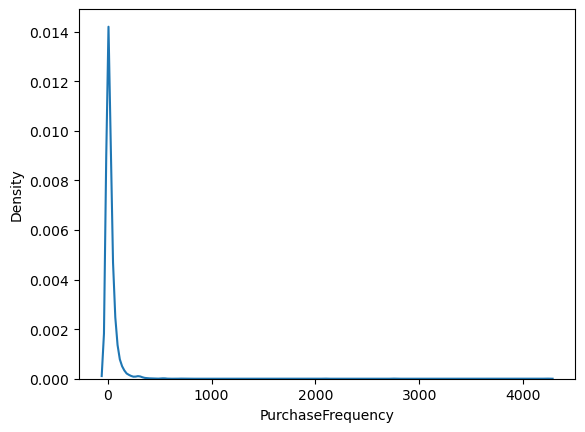

In [13]:
sns.kdeplot(df_customer, x='PurchaseFrequency')

##### Frequency scores:
5 : > 90 percentile\
4 : > 75 percentile\
3 : > 50 percentile\
2 : > 25 percentile\
1 : > 0 percentile

In [14]:
def frequency_score(val, series):
    if val >= series.quantile(0.9):
        return 5
    
    elif val >= series.quantile(0.75):
        return 4
    
    elif val >= series.quantile(0.5):
        return 3
    
    elif val >= series.quantile(0.408):
        return 2
    
    else:
        return 1
    

In [15]:
df_customer['frequency'] = df_customer.PurchaseFrequency.map(lambda x: frequency_score(x, df_customer.PurchaseFrequency))
df_customer['frequency'].value_counts()

1    1595
3     977
4     601
5     392
2     344
Name: frequency, dtype: int64

In [16]:
df_customer.head()

,recency,DaysElapsed,PurchaseFrequency,frequency
CustomerID,,,,
12747.0,10,1,33,3
12748.0,10,0,2090,5
12749.0,10,3,71,4
12820.0,10,2,34,4
12821.0,3,213,0,1


In [17]:
df['TotalPrice'] = df.UnitPrice * df.Quantity

In [18]:
df_customer['AmountSpent'] = df.groupby('CustomerID')['TotalPrice'].sum()
df_customer.head()

,recency,DaysElapsed,PurchaseFrequency,frequency,AmountSpent
CustomerID,,,,,
12747.0,10,1,33,3,4196.01
12748.0,10,0,2090,5,32937.99
12749.0,10,3,71,4,4090.88
12820.0,10,2,34,4,942.34
12821.0,3,213,0,1,92.72


<Axes: xlabel='AmountSpent', ylabel='Density'>

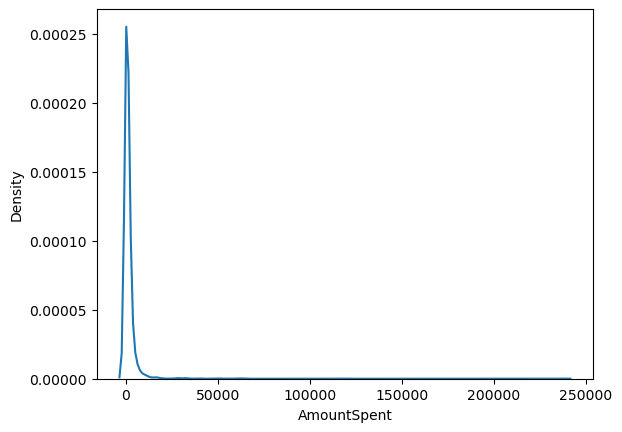

In [19]:
sns.kdeplot(df_customer, x = 'AmountSpent')

In [20]:
print(df_customer.AmountSpent.quantile(0))
print(df_customer.AmountSpent.quantile(0.25))
print(df_customer.AmountSpent.quantile(0.5))
print(df_customer.AmountSpent.quantile(0.75))

2.9
294.25
640.76
1557.7600000000002


In [21]:
df_customer.AmountSpent.describe()

count      3909.000000
mean       1716.297543
std        5993.615163
min           2.900000
25%         294.250000
50%         640.760000
75%        1557.760000
max      238169.000000
Name: AmountSpent, dtype: float64

In [22]:
def monetary_score(val, series):
    if val >= series.quantile(0.9):
        return 5
    
    elif val >= series.quantile(0.75):
        return 4
    
    elif val >= series.quantile(0.5):
        return 3
    
    elif val >= series.quantile(0.25):
        return 2
    
    else:
        return 1
    

In [23]:
df_customer['monetary'] = df_customer.AmountSpent.map(lambda x: monetary_score(x, df_customer.AmountSpent))
df_customer.head()

,recency,DaysElapsed,PurchaseFrequency,frequency,AmountSpent,monetary
CustomerID,,,,,,
12747.0,10,1,33,3,4196.01,5
12748.0,10,0,2090,5,32937.99,5
12749.0,10,3,71,4,4090.88,5
12820.0,10,2,34,4,942.34,3
12821.0,3,213,0,1,92.72,1


In [24]:
df_rfm = df_customer[['recency', 'frequency', 'monetary']]
df_kmeans = df_customer[['DaysElapsed', 'PurchaseFrequency', 'AmountSpent']]

### 1) Customer Segmentation Using RFM Model

In [25]:
df_rfm.head()

,recency,frequency,monetary
CustomerID,,,
12747.0,10,3,5
12748.0,10,5,5
12749.0,10,4,5
12820.0,10,4,3
12821.0,3,1,1


In [26]:
def segmenter(row):
    if row['recency'] in [9, 10] and row['frequency'] in [5] and row['monetary'] in [5]:
        return 'Soulmates'
    
    elif row['recency'] in [7, 8, 9, 10] and row['frequency'] in [3, 4, 5] and row['monetary'] in [3, 4, 5]:
        return 'Lovers'
    
    elif row['recency'] in [9, 10] and row['frequency'] in [1] and row['monetary'] in [4, 5]:
        return 'New passions'
    
    elif row['recency'] in [7, 8] and row['frequency'] in [5] and row['monetary'] in [5]:
        return 'Flirting'
    
    elif row['recency'] in [7, 8] and row['frequency'] in [1] and row['monetary'] in [1]:
        return 'Apprentice'
    
    elif row['recency'] in [9, 10] and row['frequency'] in [1, 2] and row['monetary'] in [9, 10]:
        return 'Potential Lovers'
    
    elif row['recency'] in [9, 10] and row['frequency'] in [5, 6, 7, 8] and row['monetary'] in [5, 6, 7, 8]:
        return 'Platonic Friends'
    
    elif row['recency'] in [3, 4, 5, 6] and row['frequency'] in [1,2, 3, 4, 5, 6, 7, 8, 9, 10] and row['monetary'] in [1,2, 3, 4, 5, 6, 7, 8, 9, 10]:
        return 'ATDU'
    
    elif row['recency'] in [1, 2] and row['frequency'] in [9, 10] and row['monetary'] in [9, 10]:
        return 'Ex-Lovers'
    
    elif row['recency'] in [1, 2] and row['frequency'] in [1,2] and row['monetary'] in [9, 10]:
        return 'One Night Stand'
    
    elif row['recency'] in [1, 2] and row['frequency'] in [3, 4] and row['monetary'] in [1,2]:
        return 'Break Up'
    
    else:
        return 'Unclassified'

In [27]:
df_rfm['segment'] = df_rfm.apply(segmenter, axis=1)

/tmp/ipykernel_2129/842370909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['segment'] = df_rfm.apply(segmenter, axis=1)


In [30]:
df_rfm['segment'].value_counts()

Unclassified    1671
Lovers          1212
ATDU             799
Soulmates        153
Apprentice        74
Name: segment, dtype: int64

In [31]:
df_rfm[df_rfm.segment == 'Unclassified']

,recency,frequency,monetary,segment
CustomerID,,,,
12822.0,7,1,3,Unclassified
12823.0,7,1,4,Unclassified
12824.0,8,3,2,Unclassified
12827.0,10,3,2,Unclassified
12829.0,1,1,1,Unclassified
...,...,...,...,...
18274.0,9,3,1,Unclassified
18276.0,8,3,2,Unclassified
18277.0,8,2,1,Unclassified


### 1) Customer Segmentation Using K-Means

In [32]:
df_kmeans.head()

,DaysElapsed,PurchaseFrequency,AmountSpent
CustomerID,,,
12747.0,1,33,4196.01
12748.0,0,2090,32937.99
12749.0,3,71,4090.88
12820.0,2,34,942.34
12821.0,213,0,92.72
